# Add group label for test dataset

In [1]:
import pandas as pd

train_path = "data/Product10K/train.csv"
test_path = "data/Product10K/test_kaggletest.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print(f"train: {train_df.shape}, test: {test_df.shape}")

train: (141931, 3), test: (55376, 3)


In [2]:
train_df.head()

,name,class,group
0,1.jpg,0,0
1,2.jpg,0,0
2,3.jpg,0,0
3,4.jpg,0,0
4,5.jpg,0,0


In [3]:
test_df.head()

,name,class,Usage
0,3963142.jpg,0,Public
1,1209854.jpg,0,Public
2,8638678.jpg,0,Private
3,6997109.jpg,0,Private
4,3134887.jpg,0,Private


In [ ]:
class_group = {}

for i, row in train_df.iterrows():
    if row['class'] not in class_group:
        class_group[row['class']] = row['group']
    else:
        if class_group[row['class']] != row['group']:
            print(f"mismatched class group")

# class_group

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 3,
 6: 5,
 7: 6,
 8: 3,
 9: 7,
 10: 8,
 11: 9,
 12: 5,
 13: 0,
 14: 9,
 15: 1,
 16: 1,
 17: 9,
 18: 5,
 19: 0,
 20: 10,
 21: 11,
 22: 0,
 23: 0,
 24: 0,
 25: 6,
 26: 7,
 27: 12,
 28: 13,
 29: 14,
 30: 15,
 31: 16,
 32: 17,
 33: 18,
 34: 0,
 35: 4,
 36: 7,
 37: 19,
 38: 16,
 39: 20,
 40: 9,
 41: 15,
 42: 7,
 43: 2,
 44: 18,
 45: 16,
 46: 18,
 47: 0,
 48: 15,
 49: 18,
 50: 1,
 51: 4,
 52: 0,
 53: 7,
 54: 9,
 55: 16,
 56: 4,
 57: 3,
 58: 8,
 59: 6,
 60: 15,
 61: 18,
 62: 21,
 63: 15,
 64: 1,
 65: 11,
 66: 17,
 67: 8,
 68: 11,
 69: 0,
 70: 21,
 71: 6,
 72: 6,
 73: 17,
 74: 3,
 75: 1,
 76: 3,
 77: 13,
 78: 0,
 79: 13,
 80: 13,
 81: 18,
 82: 3,
 83: 13,
 84: 21,
 85: 20,
 86: 12,
 87: 22,
 88: 21,
 89: 21,
 90: 20,
 91: 17,
 92: 0,
 93: 7,
 94: 9,
 95: 16,
 96: 22,
 97: 16,
 98: 9,
 99: 5,
 100: 2,
 101: 0,
 102: 3,
 103: 21,
 104: 0,
 105: 6,
 106: 11,
 107: 6,
 108: 8,
 109: 3,
 110: 11,
 111: 6,
 112: 0,
 113: 14,
 114: 14,
 115: 16,
 116: 0,
 117: 2

In [5]:
test_df['group'] = test_df['class'].apply(lambda x: class_group[x])
test_df.head()

,name,class,Usage,group
0,3963142.jpg,0,Public,0
1,1209854.jpg,0,Public,0
2,8638678.jpg,0,Private,0
3,6997109.jpg,0,Private,0
4,3134887.jpg,0,Private,0


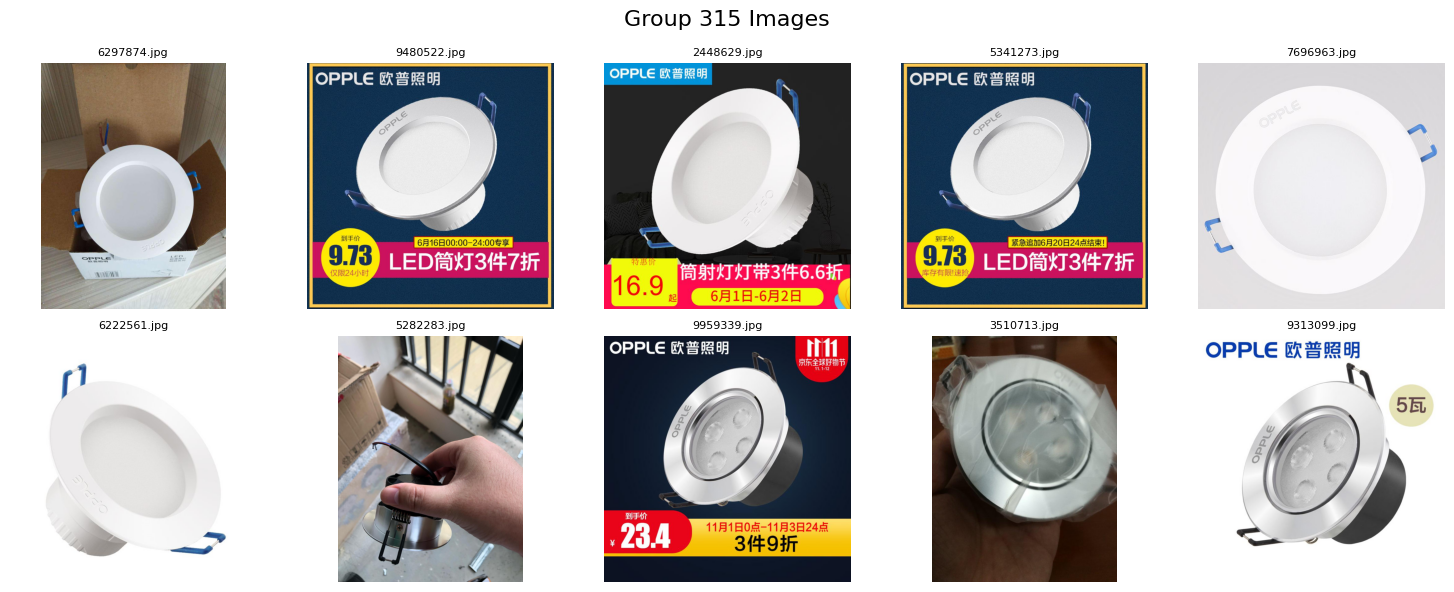

Showing 10 images from group 315


In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Specify group number
group_number = 315

# Filter images from the specified group
group_images = test_df[test_df['group'] == group_number]['name'].head(10).tolist()

# Create figure with 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle(f'Group {group_number} Images', fontsize=16)

# Display images
for i, img_name in enumerate(group_images):
    row = i // 5
    col = i % 5
    
    # Load and display image
    img_path = os.path.join("data/Product10K/test", img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(img_name, fontsize=8)
        axes[row, col].axis('off')
    else:
        axes[row, col].text(0.5, 0.5, f'{img_name}\nNot Found', 
                           ha='center', va='center', transform=axes[row, col].transAxes)
        axes[row, col].axis('off')

# Hide empty subplots if less than 10 images
for i in range(len(group_images), 10):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Showing {len(group_images)} images from group {group_number}")


In [16]:
import boto3
import json
import base64
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import random

# Initialize Bedrock client
bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-west-2')

def encode_image_to_base64(image_path):
    """Convert image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def call_claude_for_group(group_num, image_names):
    """Call Claude 3.7 to get group label for a set of images"""
    try:
        # Prepare images for Claude
        images_data = []
        for img_name in image_names[:5]:  # Take only first 5 images
            img_path = os.path.join("data/Product10K/test", img_name)
            if os.path.exists(img_path):
                img_base64 = encode_image_to_base64(img_path)
                images_data.append({
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": img_base64
                    }
                })
        
        if not images_data:
            return group_num, "No valid images found"
        
        # Prepare the message content
        content = [
            {
                "type": "text",
                "text": "请看这些产品图片，提供一个简洁准确的细分商品类别标签，最好地描述这些是什么类型的产品。专注于主要的产品类别（例如：'电子产品'、'服装'、'家居用品'、'运动器材'等）。请只回答类别名称，不需要额外说明。"
            }
        ] + images_data
        
        # Prepare the request
        request_body = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 50,
            "temperature": 0.1,
            "messages": [
                {
                    "role": "user",
                    "content": content
                }
            ]
        }
        
        # Call Bedrock
        response = bedrock_runtime.invoke_model(
            modelId="anthropic.claude-3-5-sonnet-20241022-v2:0",
            body=json.dumps(request_body)
        )
        
        # Parse response
        response_body = json.loads(response['body'].read())
        label = response_body['content'][0]['text'].strip()
        
        print(f"Group {group_num}: {label}")
        return group_num, label
        
    except Exception as e:
        print(f"Error processing group {group_num}: {str(e)}")
        return group_num, f"Error: {str(e)}"

# Get unique groups and sample images
unique_groups = test_df['group'].unique()
print(f"Total groups to process: {len(unique_groups)}")

# Prepare data for concurrent processing
group_data = []
for group in unique_groups:
    group_images = test_df[test_df['group'] == group]['name'].tolist()
    # Randomly sample 5 images from the group
    sampled_images = random.sample(group_images, min(5, len(group_images)))
    group_data.append((group, sampled_images))

# Process groups concurrently
group_labels = {}
max_workers = 5  # Limit concurrent requests to avoid rate limits

print("Starting concurrent Claude API calls...")
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Submit all tasks
    future_to_group = {
        executor.submit(call_claude_for_group, group, images): group 
        for group, images in group_data
    }
    
    # Process completed tasks
    for future in as_completed(future_to_group):
        group_num, label = future.result()
        group_labels[group_num] = label
        
        # Add small delay to respect rate limits
        time.sleep(0.1)

print(f"\nCompleted processing {len(group_labels)} groups")
print("\nGroup Labels:")
for group, label in sorted(group_labels.items()):
    print(f"Group {group}: {label}")


Total groups to process: 360
Starting concurrent Claude API calls...


Group 2: 冬季服装 - 羽绒服
Group 0: 服装类 - 男装/时尚服饰
Group 1: 服装类 - 外套/夹克
Group 4: 儿童运动服装
Group 3: 工装/工作服
Group 6: 户外运动服装/冲锋衣
Group 7: 保暖内衣
Group 5: 服装 - 男装冬季服饰（包括格子衬衫和羽绒服）
Group 8: 儿童冬季外套/羽绒服
Group 11: 男士西装/正装
Group 12: 睡衣/家居服
Group 9: 运动服装
Group 10: 服装 - 基础款T恤
Group 13: 冬季服装/羽绒服
Group 14: 男装外套
Group 15: 婴幼儿服装
Group 16: 男士外套/大衣
Group 17: 内衣/保暖内衣
Group 18: 运动服装
Group 19: 运动服装
Group 20: 男装服饰 - 冬季保暖类
Group 22: 儿童礼服服装
Group 21: 男士POLO衫
Group 23: 运动服装
Group 24: 运动休闲裤
Group 26: 男士内衣
Group 27: 内衣/贴身衣物
Group 25: 休闲服装
Group 29: 女装裤装
Group 30: 女装短裤/休闲裤
Group 32: 保暖裤装/冬季服装
Group 28: 牛仔裤服装
Group 31: 打底裤/紧身裤
Group 33: 女装裙装
Group 34: 女装 - 职业装裤装
Group 36: 鞋类
Group 37: 运动鞋、洗涤用品
Group 38: 运动鞋/休闲鞋
Group 35: 凉鞋/休闲鞋
Group 40: 运动鞋
Group 42: 女靴/短靴
Group 41: 休闲鞋/帆布鞋
Group 39: 雪地靴
Group 43: 劳保鞋
Group 44: 户外登山靴/战术靴
Group 47: 休闲运动鞋
Group 46: 男士正装皮鞋
Group 48: 女靴
Group 45: 鞋类/运动鞋
Group 49: 运动鞋
Group 50: 女鞋 - 高跟鞋
Group 51: 奢侈品箱包
Group 52: 日用百货（包括化妆笔盒、牙刷盒、晾衣夹等生活用品）
Group 53: 运动背包/户外包
Group 55: 皮具配饰（钱包）
Group 54: 箱包/背包类
Grou

In [22]:
group_labels[315]

'LED筒灯/嵌入式照明'